***
### Import modules : 

In [4]:
import os 
import pandas as pd 
from tqdm import tqdm
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef


***
### Read the matrices :

> TropiGATv2 DF : 

In [6]:
path_project = "/media/concha-eloko/Linux/PPT_clean"

DF_info = pd.read_csv(f"{path_project}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)

DF_info_lvl_0 = DF_info.copy()
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))

KLtypes = [kltype for kltype in dico_prophage_count if dico_prophage_count[kltype] >= 20]



***
## Working on the final matrices file :

In [27]:
path_project = "/media/concha-eloko/Linux/PPT_clean"


raw_df = pd.read_csv(f"{path_project}/raw_metrics.standard.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]

working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]


In [28]:
raw_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
0,A1a,A1a_00014,right-handed beta-helix,KL70:0.997 ; KL117:0.995 ; KL34:0.986 ; KL31:0...,0,KL151:0.599,KL151,KL151
1,A1a,A1a_00002,6-bladed beta-propeller,KL4:1.0 ; KL123:1.0 ; KL14:1.0 ; KL56:0.999 ; ...,0,KL102:0.737,0,KL151
2,A1b,A1b_00048,right-handed beta-helix,KL149:1.0 ; KL155:1.0 ; KL128:0.999 ; KL28:0.9...,KL157,No_associations,0,KL157
3,A1b,A1b_00036,6-bladed beta-propeller,KL56:1.0 ; KL4:1.0 ; KL123:1.0 ; KL7:1.0 ; KL1...,0,KL102:0.737,0,KL157
4,A1c,A1c_00046,6-bladed beta-propeller,KL56:1.0 ; KL4:1.0 ; KL123:1.0 ; KL7:1.0 ; KL1...,0,KL102:0.737,0,KL1
...,...,...,...,...,...,...,...,...
198,S13a,S13a_00036,right-handed beta-helix,KL70:1.0 ; KL12:0.997 ; KL149:0.995 ; KL56:0.9...,KL149,No_associations,0,"KL149,KL102"
199,S13b,S13b_00058,right-handed beta-helix,KL47:1.0 ; KL103:1.0 ; KL34:1.0 ; KL149:1.0 ; ...,KL63,KL63:0.641,KL63,KL63
200,S13c,S13c_00055,right-handed beta-helix,KL70:1.0 ; KL38:0.996 ; KL12:0.993 ; KL56:0.99...,KL149,No_associations,0,"KL149,KL102"
201,S13d,S13d_00057,right-handed beta-helix,KL155:1.0 ; KL14:0.998 ; KL149:0.991 ; KL64:0....,KL14,KL14:0.951,KL14,KL14


***
### Make the matrices files : 

In [9]:
import pandas as pd 
import os 

path_project = "/media/concha-eloko/Linux/PPT_clean"

tropigat_results = pd.read_csv(f"{path_project}/TropiGAT.results.standard.1309.tsv", sep = "\t", names = ["protein", "predictions_tropigat"])

# Seqbased_model.results.bit50.0101.tsv
# Seqbased_model.0101.results.tsv
# Seqbased_model.1001.results.tsv
seqbased_results = pd.read_csv(f"{path_project}/Seqbased_model.results.bit75.2406.tsv", sep = "\t", names = ["protein", "predictions_seqbased"])


In [29]:
from tqdm import tqdm

top_n = 15
labels_tropigat = {}
count_kltypes = {}

for kltype in tqdm(dico_prophage_count) : 
    n = 0
    pred_labels , real_labels = [] , []
    for author in dico_matrices :
        if kltype in dico_matrices[author]["pool"] : 
            matrix = dico_matrices[author]["matrix"]
            for phage in matrix["Phages"].unique() :
                top_predictions = set()
                predictions = tropigat_results[tropigat_results["Phage"] == phage]["TropiGAT_predictions"].values
                for calls in predictions : 
                    predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                    top_predictions.update(predicted_kltypes[0:top_n-1])
                if kltype in top_predictions : 
                    pred_labels.append(1)
                else : 
                    pred_labels.append(0)
                if kltype in dico_hits[phage] : 
                    real_labels.append(1)
                    n += 1 
                else :
                    real_labels.append(0)
    labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
    count_kltypes[kltype] = n 

labels_tropigat
sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))


  1%|█▏                                                                                                                                               | 1/128 [00:00<00:00, 2721.81it/s]


KeyError: 'Phage'

In [22]:
def make_labels(pred_df, predictor = "tropigat" , top_n = 15, to_ignore = []) :
    dico_pred = {"tropigat" : "TropiGAT_predictions" ,
                 "tropiseq" : "TropiSeq_predictions"}
    col = dico_pred[predictor]
    labels_tropigat = {}
    count_kltypes = {}
    for kltype in tqdm(dico_prophage_count) : 
        n = 0
        pred_labels , real_labels = [] , []
        for author in dico_matrices :
            if kltype in dico_matrices[author]["pool"] : 
                matrix = dico_matrices[author]["matrix"]
                for phage in matrix["Phages"].unique() :
                    #if phage not in to_ignore : 
                    if phage not in to_ignore and phage in pred_df["Phage"].tolist(): 
                        top_predictions = set()
                        predictions = pred_df[pred_df["Phage"] == phage][col].values
                        for calls in predictions : 
                            predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                            top_predictions.update(predicted_kltypes[0:top_n-1])
                        if kltype in top_predictions : 
                            pred_labels.append(1)
                        else : 
                            pred_labels.append(0)
                        if kltype in dico_hits[phage] : 
                            real_labels.append(1)
                            n += 1 
                        else :
                            real_labels.append(0)
        labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
        sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))
        count_kltypes[kltype] = n 
    return sorted_dict , labels_tropigat, count_kltypes


def decript_dic (sorted_dict , labels_tropigat, count_kltypes) :
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] > 0 :
                    f1 = f1_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    precision = precision_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    accuracy = accuracy_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    auc = roc_auc_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    print(kltype ,count_kltypes[kltype], round(f1,5),round(accuracy,5), round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
                #aucs.append(auc)
        except ValueError : 
            print(kltype , "error", sep = "\t")



### Work on TropiGAT : 

> Full predictions : 

In [30]:
tropigat_results_gat = tropigat_results[(tropigat_results["Targets"].str.count("pass") == 0)]

sorted_dic_tropigat, labels_tropigat, count_kltypes = make_labels(tropigat_results_gat, to_ignore = phages_to_ignore)
decript_dic(sorted_dic_tropigat, labels_tropigat, count_kltypes)

KeyError: 'Targets'

***
> Work on TropiSeq :

In [15]:
sorted_dic_tropiseq, labels_tropiseq, count_kltypes = make_labels(tropigat_results, predictor = "tropiseq",  to_ignore = phages_to_ignore)
decript_dic(sorted_dic_tropiseq, labels_tropiseq, count_kltypes)

100%|████████████████████████████████████████| 128/128 [00:01<00:00, 111.69it/s]


KL2	16	0.28571	0.87903	0.1875	0.6	0.58449	0.28797
KL3	12	0.4	0.59091	0.25	1.0	0.625	0.36274
KL4	7	0.25	0.93023	0.14286	1.0	0.57143	0.36438
KL9	1	0.66667	0.98438	1.0	0.5	0.99206	0.70147
KL13	3	0.5	0.98039	0.33333	1.0	0.66667	0.57161
KL14	10	0.16667	0.91935	0.1	0.5	0.54561	0.19719
KL15	1	1.0	1.0	1.0	1.0	1.0	1.0
KL16	4	0.57143	0.97581	0.5	0.66667	0.74583	0.56538
KL17	2	0.66667	0.98438	0.5	1.0	0.75	0.70147
KL18	1	0.0	0.95312	0.0	0.0	0.48413	-0.02263
KL20	1	0.0	0.98039	0.0	0.0	0.49505	-0.0099
KL21	1	0.5	0.96875	1.0	0.33333	0.98413	0.56811
KL23	1	0.66667	0.98438	1.0	0.5	0.99206	0.70147
KL24	5	0.4	0.94118	0.4	0.4	0.68454	0.36907
KL25	3	0.85714	0.9902	1.0	0.75	0.99495	0.86164
KL27	2	0.66667	0.98438	0.5	1.0	0.75	0.70147
KL28	14	0.1	0.85484	0.07143	0.16667	0.51299	0.03831
KL30	3	0.33333	0.96078	0.33333	0.33333	0.65657	0.31313
KL31	1	0.0	0.96875	0.0	0.0	0.49206	-0.01587
KL35	7	0.57143	0.93023	0.57143	0.57143	0.76673	0.53345
KL39	3	0.0	0.92188	0.0	0.0	0.48361	-0.03983
KL43	2	0.0	0.95312	0.0	0.0	0.

***
### Good calls : 

In [38]:
import os 
import pandas as pd 
from itertools import product

path_project = "/media/concha-eloko/Linux/PPT_clean"

raw_df = pd.read_csv(f"{path_project}/raw_metrics.standard.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]


In [39]:
working_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
0,A1a,A1a_00014,right-handed beta-helix,KL70:0.997 ; KL117:0.995 ; KL34:0.986 ; KL31:0...,0,KL151:0.599,KL151,KL151
1,A1a,A1a_00002,6-bladed beta-propeller,KL4:1.0 ; KL123:1.0 ; KL14:1.0 ; KL56:0.999 ; ...,0,KL102:0.737,0,KL151
2,A1b,A1b_00048,right-handed beta-helix,KL149:1.0 ; KL155:1.0 ; KL128:0.999 ; KL28:0.9...,KL157,No_associations,0,KL157
3,A1b,A1b_00036,6-bladed beta-propeller,KL56:1.0 ; KL4:1.0 ; KL123:1.0 ; KL7:1.0 ; KL1...,0,KL102:0.737,0,KL157
4,A1c,A1c_00046,6-bladed beta-propeller,KL56:1.0 ; KL4:1.0 ; KL123:1.0 ; KL7:1.0 ; KL1...,0,KL102:0.737,0,KL1
...,...,...,...,...,...,...,...,...
198,S13a,S13a_00036,right-handed beta-helix,KL70:1.0 ; KL12:0.997 ; KL149:0.995 ; KL56:0.9...,KL149,No_associations,0,"KL149,KL102"
199,S13b,S13b_00058,right-handed beta-helix,KL47:1.0 ; KL103:1.0 ; KL34:1.0 ; KL149:1.0 ; ...,KL63,KL63:0.641,KL63,KL63
200,S13c,S13c_00055,right-handed beta-helix,KL70:1.0 ; KL38:0.996 ; KL12:0.993 ; KL56:0.99...,KL149,No_associations,0,"KL149,KL102"
201,S13d,S13d_00057,right-handed beta-helix,KL155:1.0 ; KL14:0.998 ; KL149:0.991 ; KL64:0....,KL14,KL14:0.951,KL14,KL14


> Functions : 

In [33]:
def get_all_combinations(raw_df, to_ignore = []) :
    all_combinations = set()
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_list = list(set(tmp_df["Targets"].tolist()[0].split(",")))
            combinations = set(product([phage], targets_list))
            all_combinations = all_combinations.union(combinations)
    return all_combinations

In [34]:
def get_calls_metrics(raw_df , with_fold = False ,top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_good_calls = []
    TropiSeq_good_calls = []
    
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            combinations = set(product([phage], list(targets_set)))
            total_calls = total_calls + list(combinations)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                # TropiGAT calls : 
                call_tropigat = set()
                for calls in tmp_df["TropiGAT_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropigat.update(top_n_predictions)
                good_calls_tropigat = call_tropigat.intersection(targets_set)
                if len(good_calls_tropigat) > 0 :
                    for kltype in good_calls_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_good_calls.append(a)
                # TropiSeq calls : 
                call_tropiseq = set()
                for calls in tmp_df["TropiSeq_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropiseq.update(top_n_predictions)
                good_calls_tropiseq = call_tropiseq.intersection(targets_set)
                if len(good_calls_tropiseq) > 0 :
                    for kltype in good_calls_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_good_calls.append(a)
    all_calls = set(TropiGAT_good_calls).union(set(TropiSeq_good_calls))

    return total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls


In [35]:
def get_bad_calls_metrics(raw_df , top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_bad_calls = []
    TropiSeq_bad_calls = []
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                total_calls += n_targets
                # TropiGAT calls : 
                top_n_predictions_all = []
                for calls in tmp_df["TropiGAT_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    top_n_predictions_all = top_n_predictions_all + top_n_predictions
                bad_call_tropigat = targets_set - set(top_n_predictions_all)
                if len(bad_call_tropigat) > 0 :
                    for kltype in bad_call_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_bad_calls.append(a)                        
                # TropiSeq calls : 
                top_n_predictions_all = []
                for calls in tmp_df["TropiSeq_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    top_n_predictions_all = top_n_predictions_all + top_n_predictions
                bad_call_tropiseq = targets_set - set(top_n_predictions_all)
                if len(bad_call_tropiseq) > 0 :
                    for kltype in bad_call_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_bad_calls.append(a)
    all_calls = set(TropiGAT_bad_calls).union(set(TropiSeq_bad_calls))

    return total_calls, all_calls , TropiGAT_bad_calls , TropiSeq_bad_calls

> All predictions : 

In [36]:
from collections import Counter
combinations = get_all_combinations(working_df)
len(combinations)
combinations

kltypes = [item[1] for item in combinations]
Counter(kltypes)

Counter({'KL3': 12,
         'KL2': 12,
         'KL14': 9,
         'KL37': 9,
         'KL22': 9,
         'KL53': 8,
         'KL57': 8,
         'KL28': 8,
         'KL38': 7,
         'KL29': 7,
         'KL158': 6,
         'KLL36': 6,
         'KL4': 6,
         'KLL56': 5,
         'KL35': 5,
         'KL64': 5,
         'KLL11': 5,
         'KLL69': 4,
         'KLL2': 4,
         'KLL64': 4,
         'KLL29': 4,
         'KLL35': 4,
         'KL16': 4,
         'KLL7': 4,
         'KL126': 4,
         'KLL70': 3,
         'KL140': 3,
         'KLL39': 3,
         'KL61': 3,
         'KLL32': 3,
         'KLL54': 3,
         'KLL30': 3,
         'KLL68': 3,
         'KLL58': 3,
         'KLL13': 3,
         'KLL49': 3,
         'KLL60': 3,
         'KLL21': 3,
         'KLL27': 3,
         'KLL37': 3,
         'KLL65': 3,
         'KL74': 3,
         'KLL67': 2,
         'KLL24': 2,
         'KLL71': 2,
         'KLL18': 2,
         'KLL57': 2,
         'KLL62': 2,
         'K

In [40]:
total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = 45, to_ignore = phages_to_ignore)
len(total_calls), len(all_calls) , len(TropiGAT_good_calls) , len(TropiSeq_good_calls)


(292, 79, 66, 27)

In [ ]:
(274, 111, 93, 47)

In [41]:
def get_n_KLtypes(calls) : 
    n = len(set([item[1] for item in calls]))
    return n

TropiGAT_good_calls

[('A1b', 'KL157'),
 ('A1c', 'KL1'),
 ('A1d', 'KL20'),
 ('A1g', 'KL16'),
 ('A1h', 'KL2'),
 ('A1l', 'KL22'),
 ('D7b', 'KL140'),
 ('D7c', 'KL28'),
 ('DIMCIIMF', 'KL28'),
 ('DJLANJJD', 'KL14'),
 ('DJLANJJD', 'KL38'),
 ('DJLANJJD', 'KL57'),
 ('DJLANJJD', 'KL4'),
 ('EHPPICDA', 'KL3'),
 ('EHPPICDA', 'KL38'),
 ('EHPPICDA', 'KL53'),
 ('EHPPICDA', 'KL57'),
 ('EKPIEFBL', 'KL74'),
 ('EKPIEFBL', 'KL4'),
 ('EKPIEFBL', 'KL29'),
 ('EKPIEFBL', 'KL3'),
 ('EKPIEFBL', 'KL38'),
 ('EKPIEFBL', 'KL57'),
 ('FADJDIKG', 'KL74'),
 ('FADJDIKG', 'KL4'),
 ('FADJDIKG', 'KL29'),
 ('FADJDIKG', 'KL3'),
 ('FADJDIKG', 'KL57'),
 ('GCLPFEGH', 'KL4'),
 ('GCLPFEGH', 'KL53'),
 ('GCLPFEGH', 'KL3'),
 ('GCLPFEGH', 'KL38'),
 ('GCLPFEGH', 'KL57'),
 ('HIIECEMK', 'KL2'),
 ('INMBNBLA', 'KL29'),
 ('INMBNBLA', 'KL3'),
 ('INMBNBLA', 'KL38'),
 ('INMBNBLA', 'KL57'),
 ('IPGJFKPH', 'KL3'),
 ('IPGJFKPH', 'KL38'),
 ('IPGJFKPH', 'KL57'),
 ('IPGJFKPH', 'KL4'),
 ('KBDEFBCI', 'KL35'),
 ('LCALLHIG', 'KL3'),
 ('M5a', 'KL103'),
 ('NBNDMPCG', 'KL35'),

***
### Look into the folds : 

In [1]:
import os 
import pandas as pd 
from itertools import product
from collections import defaultdict
from tqdm import tqdm

path_project = "/media/concha-eloko/Linux/PPT_clean"

raw_df = pd.read_csv(f"{path_project}/raw_metrics.classic_2002.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]

> Number of target per fold : 

In [31]:
targets_fold = defaultdict(list)

for fold in working_df["Folds"].unique() :
    for phage in working_df["Phage"].unique() :
        if fold in working_df[working_df["Phage"] == phage]["Folds"].values[0] : 
            targets_arr = working_df[working_df["Phage"] == phage]["Targets"].values[0].split(",")
            n_target = len(targets_arr)
            targets_fold[fold].append(n_target)

In [45]:
targets_fold = defaultdict(list)

for phage in working_df["Phage"].unique() :
    if "6-bladed beta-propeller" in working_df[working_df["Phage"] == phage]["Folds"].values : 
        fold = "6-bladed beta-propeller"
    else :
        fold = "others"
    targets_arr = working_df[working_df["Phage"] == phage]["Targets"].values[0].split(",")
    n_target = len(targets_arr)
    targets_fold[fold].append(n_target)

In [46]:
for fold in targets_fold : 
    print(fold, mean(targets_fold[fold]))

6-bladed beta-propeller 2.7714285714285714
others 1.6326530612244898


In [47]:
statistic, p_value = mannwhitneyu(targets_fold["6-bladed beta-propeller"], targets_fold["others"])
p_value

0.23705095510371454

> Rest

In [5]:
rhbh_df = working_df[working_df["Folds"] == "right-handed beta-helix"]
bp_df = working_df[working_df["Folds"] == "6-bladed beta-propeller"]

In [6]:
rhbh_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
1,A1a,A1a_00014,right-handed beta-helix,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...,0,KL151:0.599,KL151,KL151
2,A1b,A1b_00048,right-handed beta-helix,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...,0,No predictions,0,KL157
5,A1c,A1c_00034,right-handed beta-helix,KL52:0.998 ; KL62:0.993 ; KL128:0.981 ; KL43:0...,0,No hits,0,KL1
7,A1d,A1d_00009,right-handed beta-helix,KL23:0.983 ; KL60:0.979 ; KL52:0.962 ; KL112:0...,0,No predictions,0,KL20
13,A1g,A1g_00057,right-handed beta-helix,KL128:0.922 ; KL43:0.912 ; KL145:0.898 ; KL18:...,0,No hits,0,KL16
...,...,...,...,...,...,...,...,...
225,S13a,S13a_00036,right-handed beta-helix,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....,0,No predictions,0,"KL149,KL102"
226,S13b,S13b_00058,right-handed beta-helix,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....,0,KL63:0.641,KL63,KL63
227,S13c,S13c_00055,right-handed beta-helix,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...,0,No predictions,0,"KL149,KL102"
228,S13d,S13d_00057,right-handed beta-helix,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....,KL14,KL14:0.951,KL14,KL14


In [17]:
# TropiGAT
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(rhbh_df, predictor = "tropigat")
dico_mcc_tropigat_rh = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropigat_rh_f = {kltype : dico_mcc_tropigat_rh[kltype] for kltype in dico_mcc_tropigat_rh if dico_mcc_tropigat_rh[kltype]["lytic_phages"]["Count"]>0}

sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(bp_df, predictor = "tropigat")
dico_mcc_tropigat_bp = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropigat_bp_f = {kltype : dico_mcc_tropigat_bp[kltype] for kltype in dico_mcc_tropigat_bp if dico_mcc_tropigat_bp[kltype]["lytic_phages"]["Count"]>0}


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 164.10it/s]


In [18]:
# TropiSeq
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")
sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(rhbh_df, predictor = "tropiseq")
dico_mcc_tropiseq_rh = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropiseq_rh_f = {kltype : dico_mcc_tropiseq_rh[kltype] for kltype in dico_mcc_tropiseq_rh if dico_mcc_tropiseq_rh[kltype]["lytic_phages"]["Count"]>0}

sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(bp_df, predictor = "tropiseq")
dico_mcc_tropiseq_bp = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
dico_mcc_tropiseq_bp_f = {kltype : dico_mcc_tropiseq_bp[kltype] for kltype in dico_mcc_tropiseq_bp if dico_mcc_tropiseq_bp[kltype]["lytic_phages"]["Count"]>0}



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 177.86it/s]


> Plots :

In [19]:
from statistics import mean
from scipy.stats import mannwhitneyu

MCC_rhbh_tropigat = [dico_mcc_tropigat_rh_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropigat_rh_f]
MCC_6bp_tropigat = [dico_mcc_tropigat_bp_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropigat_bp_f]

print(mean(MCC_rhbh_tropigat) , mean(MCC_6bp_tropigat))
statistic, p_value = mannwhitneyu(MCC_rhbh_tropigat, MCC_6bp_tropigat)

p_value

0.14124516413959784 0.028963619626401035


0.00820122759658898

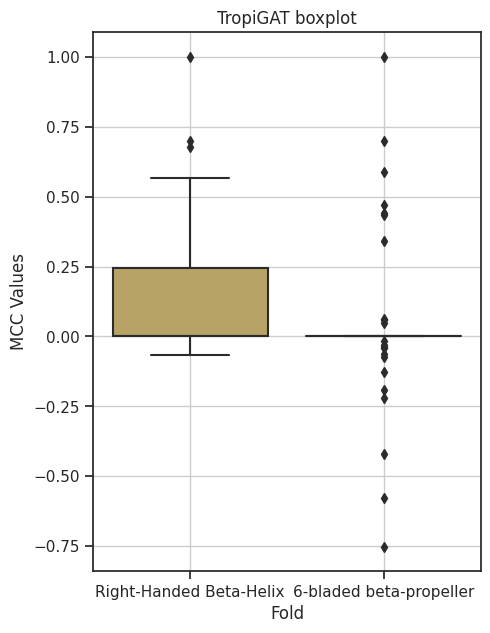

In [186]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = MCC_rhbh_tropigat
data2 = MCC_6bp_tropigat

# Combine data and corresponding labels
combined_data = np.concatenate([data1, data2])
labels = ['Right-Handed Beta-Helix'] * len(data1) + ['6-bladed beta-propeller'] * len(data2)

# Create box plot using Seaborn
plt.figure(figsize=(5, 7))
sns.boxplot(x=labels, y=combined_data, palette={'Right-Handed Beta-Helix': '#c6aa58ff', '6-bladed beta-propeller': '#8d0801ff'})

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('MCC Values')
plt.title('TropiGAT boxplot')

# Show plot
plt.grid(True)
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/fold_box_plot.TropiGAT.0203.svg', dpi = 500)
plt.show()

In [175]:
MCC_rhbh_tropiseq = [dico_mcc_tropiseq_rh_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropiseq_rh_f]
MCC_6pb_tropiseq = [dico_mcc_tropiseq_bp_f[kltype]["lytic_phages"]["MCC"] for kltype in dico_mcc_tropiseq_bp_f]

print(mean(MCC_rhbh_tropiseq) , mean(MCC_6pb_tropiseq))
statistic, p_value = mannwhitneyu(MCC_rhbh_tropiseq, MCC_6pb_tropiseq)

p_value

0.3272786731683548 0.016836953462987622


0.00017786087990218717

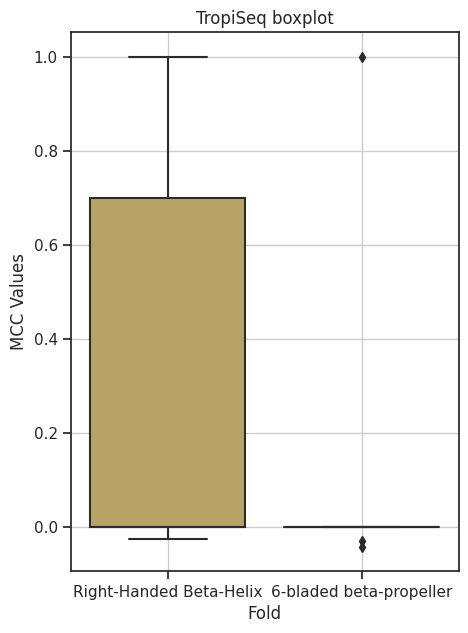

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Example data
data1 = MCC_rhbh_tropiseq
data2 = MCC_6pb_tropiseq

# Combine data and corresponding labels
combined_data = np.concatenate([data1, data2])
labels = ['Right-Handed Beta-Helix'] * len(data1) + ['6-bladed beta-propeller'] * len(data2)

# Create box plot using Seaborn
plt.figure(figsize=(5, 7))
sns.boxplot(x=labels, y=combined_data, palette={'Right-Handed Beta-Helix': '#c6aa58ff', '6-bladed beta-propeller': '#8d0801ff'})

# Add labels and title
plt.xlabel('Fold')
plt.ylabel('MCC Values')
plt.title('TropiSeq boxplot')

# Show plot
plt.grid(True)
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/fold_box_plot.TropiSeq.0203.svg', dpi = 500)
plt.show()

***
#### Old method

In [11]:
total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = 40, to_ignore = phages_to_ignore)
len(total_calls), len(all_calls) , len(TropiGAT_good_calls) , len(TropiSeq_good_calls)



(274, 111, 93, 47)

In [12]:
from statistics import mean

def get_all_combinations(raw_df, to_ignore = []) :
    all_combinations = set()
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_list = list(set(tmp_df["Targets"].tolist()[0].split(",")))
            combinations = set(product([phage], targets_list))
            all_combinations = all_combinations.union(combinations)
    return all_combinations

fold_combinations = defaultdict(list)

for phage in working_df["Phage"].unique() :
    mini_df = working_df[working_df["Phage"] == phage]
    folds = " & ".join(list(set(mini_df["Folds"].values)))
    p_kltypes = get_all_combinations(mini_df)
    n = 0 
    for combination in p_kltypes : 
        if combination in all_calls :
            n += 1
        else :
            pass
    proportion_call = n / len(p_kltypes) 
    fold_combinations[folds].append(proportion_call)


In [13]:
dico_plot = {}
for combo in fold_combinations :
    print(combo ,len(fold_combinations[combo]), mean(fold_combinations[combo]), sep = "\t")
    a = {"Count" : len(fold_combinations[combo]), 
         "Proportion Called" : mean(fold_combinations[combo])}
    dico_plot[combo] = a

6-bladed beta-propeller & right-handed beta-helix	49	0.54421768707483
6-bladed beta-propeller	15	0.32707070707070707
right-handed beta-helix	39	0.6111111111111112
6-bladed beta-propeller & triple-helix	6	0.2813131313131313
triple-helix	9	0.4148148148148148
right-handed beta-helix & triple-helix	1	0.5


In [19]:
from scipy.stats import ttest_ind, mannwhitneyu

g_bh = fold_combinations["right-handed beta-helix"] + fold_combinations["right-handed beta-helix & triple-helix"] + fold_combinations["right-handed beta-helix & triple-helix"]
g_bp = fold_combinations["6-bladed beta-propeller"] + fold_combinations["triple-helix & 6-bladed beta-propeller"] + fold_combinations["6-bladed beta-propeller & right-handed beta-helix"]

u_statistic, p_value_u = mannwhitneyu(g_bh, g_bp)

u_statistic, p_value_u, mean(g_bp) , mean(g_bh)



(1485.5, 0.22471733913428515, 0.49332386363636366, 0.6056910569105691)

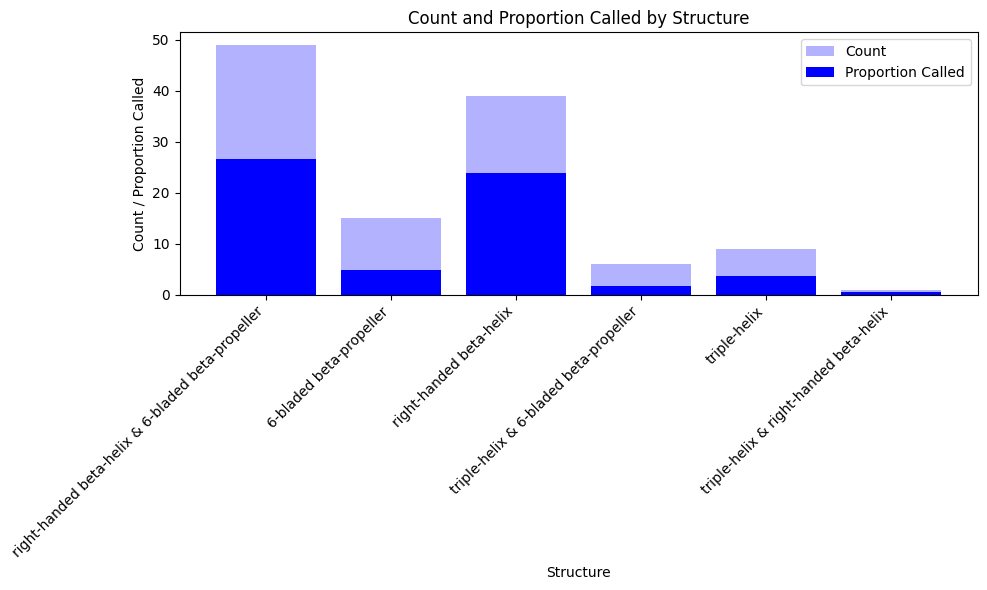

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
custom_palette = sns.color_palette(["#87CEEB", "#1E90FF"])
data = {
    'right-handed beta-helix & 6-bladed beta-propeller': {'Count': 49, 'Proportion Called': 0.54421768707483},
    '6-bladed beta-propeller': {'Count': 15, 'Proportion Called': 0.32707070707070707},
    'right-handed beta-helix': {'Count': 39, 'Proportion Called': 0.6111111111111112},
    'triple-helix & 6-bladed beta-propeller': {'Count': 6, 'Proportion Called': 0.2813131313131313},
    'triple-helix': {'Count': 9, 'Proportion Called': 0.4148148148148148},
    'triple-helix & right-handed beta-helix': {'Count': 1, 'Proportion Called': 0.5}
}

# Extract keys and values from the dictionary
keys = list(data.keys())
counts = [entry['Count'] for entry in data.values()]
proportions = [entry['Proportion Called'] for entry in data.values()]

# Plotting
plt.figure(figsize=(10, 6))

# Plot bars for count with transparency
plt.bar(keys, counts, color='blue', alpha=0.3, label='Count')

# Plot bars for proportion called
plt.bar(keys, [count * prop for count, prop in zip(counts, proportions)], color='blue', alpha=1, label='Proportion Called')

# Add labels and title
plt.xlabel('Structure')
plt.ylabel('Count / Proportion Called')
plt.title('Count and Proportion Called by Structure')
plt.legend()

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

***
### Get the random model :

In [1]:
import os 
import numpy as np
import random
import pandas as pd 
from itertools import product

path_work = "/media/concha-eloko/Linux/PPT_clean"

raw_df = pd.read_csv(f"{path_work}/raw_metrics.classic_2002.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]
kltypes_TropiGAT = pd.read_csv(f"{path_work}/TropiGAT_KLtypes.tsv", names = ["KL_types"])
kltypes_TropiSeq = pd.read_csv(f"{path_work}/TropiSeq_KLtypes.tsv", names = ["KL_types"])


> Compute the dico :

In [231]:
def random_selection_and_ranking(elements, n, m, bootstrap):
    counts = []
    for _ in range(bootstrap):
        count_top_n = 0
        for _ in range(m):
            # Step 1: Select a random element from the list
            random_element = random.choice(elements)
            # Step 2: Assign a random number between 0 and 1 to each element
            random_numbers = {element: random.random() for element in elements}
            # Step 3: Filter elements with random numbers > 0.5 and rank them
            filtered_elements = [element for element, rand_num in random_numbers.items() if rand_num > 0.5]
            ranked_elements = sorted(filtered_elements, key=lambda x: random_numbers[x], reverse=True)
            # Step 4: Check if the randomly picked element is present in the top n elements
            if random_element in ranked_elements[:n]:
                count_top_n += 1
        counts.append(count_top_n)
    
    return sum(counts) / len(counts)

In [12]:
def random_selection_and_ranking(elements, n, m, bootstrap):
    counts = []
    for _ in range(bootstrap):
        count_top_n = 0
        for _ in range(m):
            if random.choice(elements) in sorted(
                [(rand_num, element) for rand_num, element in {random.random(): element for element in elements}.items() if rand_num > 0.5],
                key=lambda x: x[1],
                reverse=True
            )[:n]:
                count_top_n += 1
        counts.append(count_top_n)
    
    return sum(counts) / len(counts)

In [233]:
%%time
random_tropigat_serie = []
random_tropiseq_serie = []

for n in range(1,41) : 
    # random tropigat
    random_tropigat = random_selection_and_ranking(kltypes_TropiGAT["KL_types"], n, 274, 1000)
    random_tropigat_serie.append(random_tropigat)
    # random tropiseq 
    random_tropiseq = random_selection_and_ranking(kltypes_TropiSeq["KL_types"], n, 274, 1000)
    random_tropiseq_serie.append(random_tropiseq)


CPU times: user 12min 12s, sys: 163 ms, total: 12min 12s
Wall time: 12min 13s


In [234]:
tropigat_serie = []
tropiseq_serie = []
total_serie = []

for n in range(1,42) : 
    total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = n, to_ignore = phages_to_ignore)
    tropigat_serie.append(len(TropiGAT_good_calls))
    tropiseq_serie.append(len(TropiSeq_good_calls))
    total_serie.append(len(all_calls))



In [235]:
dico_series = {
    "Random (TropiSeq approach)": {
        "values": [round(num) for num in random_tropiseq_serie],
        "color": "#ffdc73",
        "bold": False
    },
    "Random (TropiGAT approach)": {
        "values": [round(num) for num in random_tropigat_serie],
        "color": "#A3B18A",
        "bold": False
    },
    "TropiGAT": {
        "values": tropigat_serie[1:],
        "color": "#344E41",ResearchGate logo
        "bold": True
    },
    "TropiSeq": {
        "values": tropiseq_serie[1:],
        "color": "#a67c00",
        "bold": True
    },
    "TropiGAT + TropiSeq": {
        "values": total_serie[1:],
        "color": "#940000",
        "bold": True
    }
}

In [236]:
def clean_print(dico) :
	""" 
	Inputs : a dico
	Outputs : pretty printed dico
	"""
	import pprint
	pp = pprint.PrettyPrinter(width = 100, sort_dicts = True, compact = True)
	out = pp.pprint(dico)
	return out 

clean_print(dico_series)

{'Random (TropiGAT approach)': {'bold': False,
                                'color': '#A3B18A',
                                'values': [4, 8, 12, 16, 20, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61,
                                           65, 69, 74, 78, 82, 86, 90, 94, 98, 102, 106, 110, 114,
                                           118, 121, 124, 127, 129, 132, 133, 134, 135, 136, 136,
                                           137]},
 'Random (TropiSeq approach)': {'bold': False,
                                'color': '#ffdc73',
                                'values': [3, 6, 9, 12, 15, 18, 21, 25, 28, 31, 34, 37, 40, 43, 47,
                                           49, 52, 55, 58, 62, 65, 68, 71, 74, 77, 80, 83, 86, 89,
                                           92, 96, 98, 102, 104, 108, 111, 114, 117, 119, 122]},
 'TropiGAT': {'bold': True,
              'color': '#344E41',
              'values': [22, 29, 34, 39, 40, 47, 49, 56, 60, 62, 63, 69, 75, 78, 79, 80, 84, 89,

In [21]:
94/111*100 , 

(84.68468468468468,)

> The dico :

In [2]:
# m set to 220
dico_series_42 = {
 #'Random (TropiSeq approach)': {'bold': False,
 #                               'color': '#ffdc73',
 #                               'values': [3, 5, 8, 10, 13, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37,
 #                                          40, 42, 45, 47, 50, 52, 55, 57, 60, 62, 65, 67, 70, 72,
 #                                          75, 77, 80, 82, 85, 87, 90, 92, 94, 97, 99]},
    'TropiGAT': {'bold': False,
              'color': '#344E41',
              'values': [22, 29, 34, 39, 40, 47, 49, 56, 60, 62, 63, 69, 75, 78, 79, 80, 84, 89, 90,
                         91, 91, 91, 91, 91, 92, 92, 92, 92, 92, 92, 92, 92, 93, 93, 93, 93, 93, 93,
                         93, 93]},
    'TropiSeq': {'bold': False,
              'color': '#a67c00',
              'values': [34, 40, 40, 46, 46, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
                         47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47,
                         47, 47]},
    'TropiGAT & TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [45, 55, 58, 65, 66, 72, 73, 78, 80, 82, 83, 88, 94, 96, 97, 98,
                                    102, 107, 108, 109, 109, 109, 109, 109, 110, 110, 110, 110, 110,
                                    110, 110, 110, 111, 111, 111, 111, 111, 111, 111, 111]},
    'Random': {'bold': False,
               'color': '#A3B18A',
               'values': [3, 7, 10, 13, 17, 20, 23, 26, 30, 33, 36, 40, 43, 46, 50,
                       53, 56, 60, 63, 67, 70, 73, 76, 80, 83, 86, 89, 93, 96,
                       98, 101, 103, 104, 106, 108, 108, 110, 110, 110, 111]},

}

In [9]:
34/47*100

72.3404255319149

In [3]:
diferrences = [comb - rand for comb,rand in tuple(zip(dico_series_42["TropiGAT"]["values"] , dico_series_42["Random"]["values"]))]


In [4]:
diferrences = [comb - rand for comb,rand in tuple(zip(dico_series_42["TropiGAT + TropiSeq"]["values"] , dico_series_42["Random"]["values"]))]


KeyError: 'TropiGAT + TropiSeq'

In [5]:
diferrences = [comb - rand for comb,rand in tuple(zip(dico_series_42["TropiSeq"]["values"] , dico_series_42["Random"]["values"]))]



In [180]:
92/220*100

41.81818181818181

In [1]:
47/274*100

17.153284671532848

In [104]:
dico_series = {'Random (TropiGAT approach)': {'bold': False,
                                'color': '#A3B18A',
                                'values': [3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43, 47, 50,
                                           53, 56, 59, 63, 66]},
 'Random (TropiSeq approach)': {'bold': False,
                                'color': '#ffdc73',
                                'values': [2, 5, 8, 10, 12, 15, 17, 20, 22, 25, 27, 30, 32, 35, 37,
                                           40, 42, 45, 47, 50]},
 'TropiGAT': {'bold': True,
              'color': '#344E41',
              'values': [22, 29, 34, 39, 40, 47, 49, 56, 60, 62, 63, 69, 75, 78, 79, 80, 84, 89, 90,
                         91]},
 'TropiGAT + TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [43, 54, 56, 57, 58, 65, 67, 74, 78, 80, 81, 86, 92, 94, 95, 96,
                                    100, 105, 106, 107]},
 'TropiSeq': {'bold': True,
              'color': '#a67c00',
              'values': [31, 37, 37, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
                         39]}}

In [146]:
dico_series = {'Random': {'bold': False,
                                'color': '#A3B18A',
                                'values': [3, 6, 10, 13, 17, 20, 23, 27, 30, 33, 37, 40, 43, 47, 50,
                                           53, 56, 59, 63, 66]},
 'TropiGAT': {'bold': True,
              'color': '#344E41',
              'values': [22, 29, 34, 39, 40, 47, 49, 56, 60, 62, 63, 69, 75, 78, 79, 80, 84, 89, 90,
                         91]},
 'TropiGAT + TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [43, 54, 56, 57, 58, 65, 67, 74, 78, 80, 81, 86, 92, 94, 95, 96,
                                    100, 105, 106, 107]},
 'TropiSeq': {'bold': True,
              'color': '#a67c00',
              'values': [31, 37, 37, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39,
                         39]}}

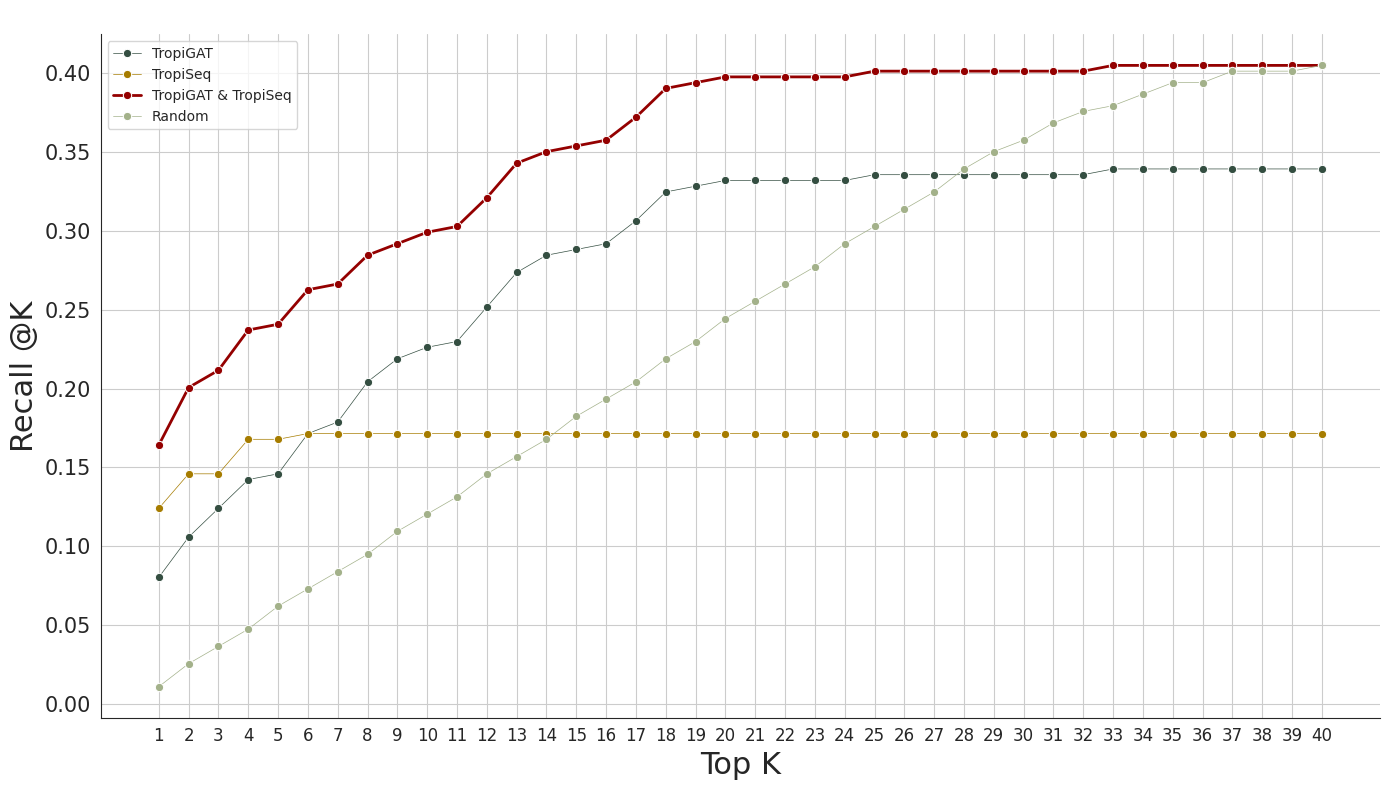

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define colors and line styles

sns.set_style("white")
sns.set_palette("muted")

# Plot each data series
plt.figure(figsize=(14, 8))
for label, series_info in dico_series_42.items():
    #values = series_info["values"]
    values = [num/274 for num in series_info["values"]]
    color = series_info["color"]
    bold = series_info["bold"]
    linestyle = '-' if bold else '-'
    linewidth = 2 if bold else 0.5
    sns.lineplot(x=range(1, len(values) + 1), y=values, label=label, marker='o', linestyle=linestyle, color=color, linewidth=linewidth, markersize=6)

# Customize the plot
plt.title(' ', fontsize=16)
plt.xlabel('Top K', fontsize=22)
plt.ylabel('Recall @K', fontsize=22)
plt.xticks(fontsize=12, rotation=0)  # Rotate x-axis tick labels horizontally
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=10)
plt.grid(True)

# Adjust x-axis ticks to integers
plt.xticks(range(1, len(values) + 1))

# Adjust spines
sns.despine()

plt.tight_layout()
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/Recall@K_PPT_Random.1704.lytic.svg', dpi = 500)
plt.show()


> Number of KL types detected across @K

In [14]:
tropigat_kltypes_serie = []
tropiseq_kltypes_serie = []
total_kltypes_serie = []

def get_n_KLtypes(calls, detail = False) :
    n = len(set([item[1] for item in calls]))
    if detail :
        return n, set([item[1] for item in calls])
    else :
        return n 
    
for n in range(1,42) : 
    total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = n, to_ignore = phages_to_ignore)
    tropigat_kltypes_serie.append(get_n_KLtypes(TropiGAT_good_calls))
    tropiseq_kltypes_serie.append(get_n_KLtypes(TropiSeq_good_calls))
    total_kltypes_serie.append(get_n_KLtypes(all_calls))




NameError: name 'get_calls_metrics' is not defined

In [36]:
dico_kltypes_series = {
    "TropiGAT": {
        "values": tropigat_kltypes_serie[1:],
        "color": "#344E41",
        "bold": False
    },
    "TropiSeq": {
        "values": tropiseq_kltypes_serie[1:],
        "color": "#a67c00",
        "bold": False
    },
    "TropiGAT + TropiSeq": {
        "values": total_kltypes_serie[1:],
        "color": "#940000",
        "bold": True
    }
}

In [40]:
def clean_print(dico) :
	""" 
	Inputs : a dico
	Outputs : pretty printed dico
	"""
	import pprint
	pp = pprint.PrettyPrinter(width = 100, sort_dicts = True, compact = True)
	out = pp.pprint(dico)
	return out 

clean_print(dico_kltypes_series)

{'TropiGAT': {'bold': True,
              'color': '#344E41',
              'values': [17, 21, 23, 25, 25, 27, 28, 28, 30, 30, 30, 32, 33, 34, 34, 34, 34, 34, 34,
                         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35,
                         35, 35]},
 'TropiGAT + TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [30, 35, 37, 38, 38, 40, 41, 41, 42, 42, 42, 43, 44, 44, 44, 44,
                                    44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
                                    45, 45, 45, 45, 45, 45, 45, 45]},
 'TropiSeq': {'bold': True,
              'color': '#a67c00',
              'values': [23, 25, 25, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
                         27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
                         27, 27]}}


In [19]:
dico_kltypes_series = {'TropiGAT': {'bold': False,
              'color': '#344E41',
              'values': [17, 21, 23, 25, 25, 27, 28, 28, 30, 30, 30, 32, 33, 34, 34, 34, 34, 34, 34,
                         34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 35, 35, 35, 35, 35,
                         35, 35]},
 'TropiGAT + TropiSeq': {'bold': True,
                         'color': '#940000',
                         'values': [30, 35, 37, 38, 38, 40, 41, 41, 42, 42, 42, 43, 44, 44, 44, 44,
                                    44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44,
                                    45, 45, 45, 45, 45, 45, 45, 45]},
 'TropiSeq': {'bold': False,
              'color': '#a67c00',
              'values': [23, 25, 25, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
                         27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
                         27, 27]}}

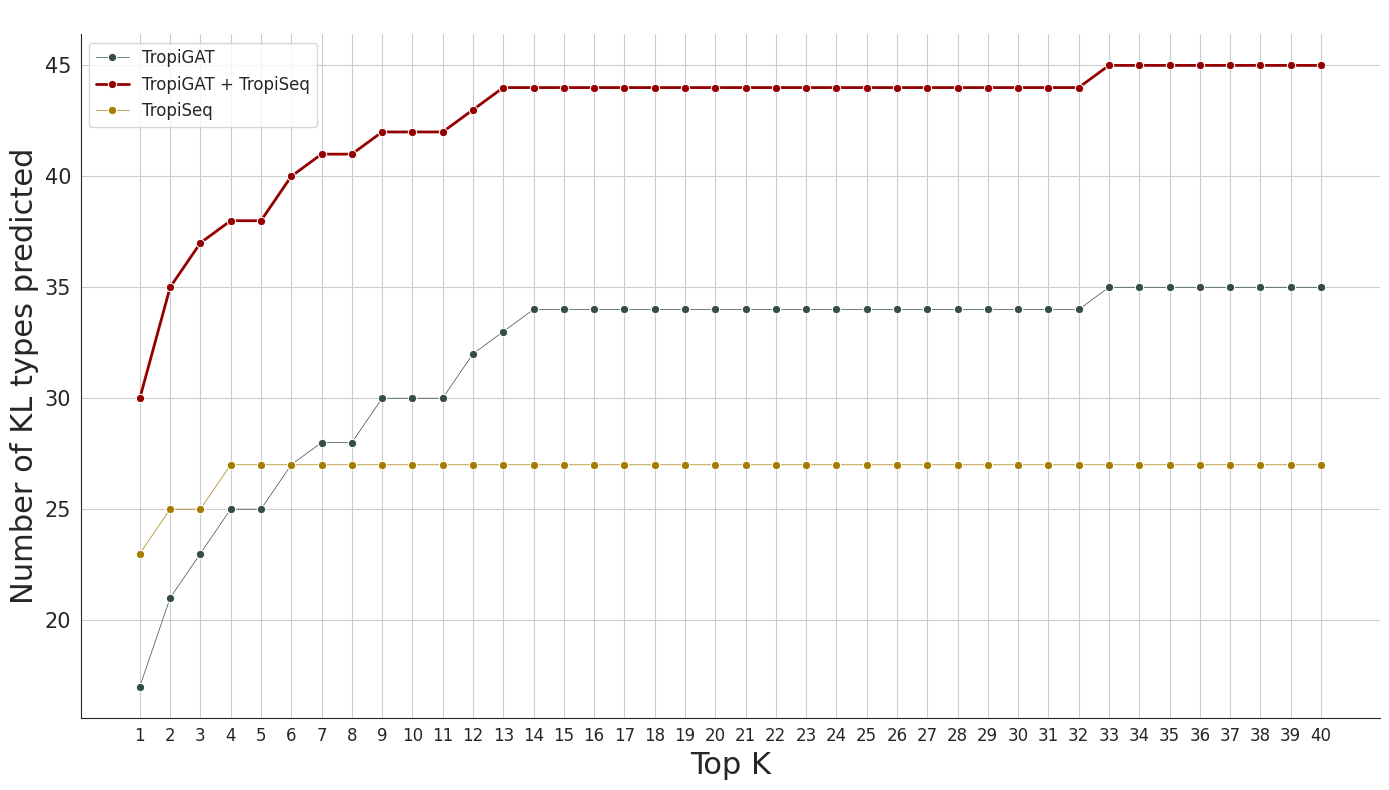

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define colors and line styles

sns.set_style("white")
sns.set_palette("muted")

# Plot each data series
plt.figure(figsize=(14, 8))
for label, series_info in dico_kltypes_series.items():
    #values = series_info["values"]
    values = [num for num in series_info["values"]]
    color = series_info["color"]
    bold = series_info["bold"]
    linestyle = '-' if bold else '-'
    linewidth = 2 if bold else 0.5
    sns.lineplot(x=range(1, len(values) + 1), y=values, label=label, marker='o', linestyle=linestyle, color=color, linewidth=linewidth, markersize=6)

# Customize the plot
plt.title(' ', fontsize=16)
plt.xlabel('Top K', fontsize=22)
plt.ylabel('Number of KL types predicted', fontsize=22)
plt.xticks(fontsize=12, rotation=0)  # Rotate x-axis tick labels horizontally
plt.yticks(fontsize=15)
plt.legend(loc='upper left', fontsize=12)
plt.grid(True)

# Adjust x-axis ticks to integers
plt.xticks(range(1, len(values) + 1))

# Adjust spines
sns.despine()

plt.tight_layout()
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/nKLtypes@K_PPT_Random.1714.lytic.svg', dpi = 500)
plt.show()

In [21]:
total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls = get_calls_metrics(working_df, top_n = 20, to_ignore = phages_to_ignore)

kl_tropigat = get_n_KLtypes(TropiGAT_good_calls, detail = True)

kl_tropiseq = get_n_KLtypes(TropiSeq_good_calls, detail = True)




In [53]:
all_types = get_n_KLtypes(total_calls,detail = True)

ignored_KLtypes = list(all_types[1] - (kl_tropigat[1] | kl_tropiseq[1]))
ignored_KLtypes.sort(key=lambda x: int(x.split("KL")[1]))
ignored_KLtypes

['KL1',
 'KL4',
 'KL5',
 'KL6',
 'KL7',
 'KL8',
 'KL11',
 'KL12',
 'KL20',
 'KL23',
 'KL26',
 'KL31',
 'KL32',
 'KL33',
 'KL40',
 'KL41',
 'KL42',
 'KL44',
 'KL50',
 'KL54',
 'KL55',
 'KL59',
 'KL61',
 'KL65',
 'KL67',
 'KL68',
 'KL69',
 'KL70',
 'KL71',
 'KL72',
 'KL79',
 'KL80',
 'KL82',
 'KL102',
 'KL103',
 'KL126',
 'KL134',
 'KL140',
 'KL144',
 'KL149',
 'KL157',
 'KL158']

In [49]:
all_types[1] - (kl_tropigat[1] | kl_tropiseq[1])

{'KL1',
 'KL102',
 'KL103',
 'KL11',
 'KL12',
 'KL126',
 'KL134',
 'KL140',
 'KL144',
 'KL149',
 'KL157',
 'KL158',
 'KL20',
 'KL23',
 'KL26',
 'KL31',
 'KL32',
 'KL33',
 'KL4',
 'KL40',
 'KL41',
 'KL42',
 'KL44',
 'KL5',
 'KL50',
 'KL54',
 'KL55',
 'KL59',
 'KL6',
 'KL61',
 'KL65',
 'KL67',
 'KL68',
 'KL69',
 'KL7',
 'KL70',
 'KL71',
 'KL72',
 'KL79',
 'KL8',
 'KL80',
 'KL82'}

In [37]:
kl_tropigat, kl_tropiseq

((34,
  {'KL10',
   'KL110',
   'KL13',
   'KL136',
   'KL14',
   'KL15',
   'KL16',
   'KL17',
   'KL18',
   'KL19',
   'KL2',
   'KL21',
   'KL22',
   'KL24',
   'KL25',
   'KL27',
   'KL28',
   'KL29',
   'KL3',
   'KL36',
   'KL38',
   'KL39',
   'KL43',
   'KL45',
   'KL46',
   'KL48',
   'KL52',
   'KL53',
   'KL57',
   'KL60',
   'KL62',
   'KL64',
   'KL74',
   'KL9'}),
 (27,
  {'KL110',
   'KL136',
   'KL139',
   'KL14',
   'KL15',
   'KL151',
   'KL16',
   'KL17',
   'KL18',
   'KL2',
   'KL21',
   'KL22',
   'KL24',
   'KL25',
   'KL27',
   'KL3',
   'KL30',
   'KL35',
   'KL37',
   'KL45',
   'KL51',
   'KL56',
   'KL57',
   'KL58',
   'KL63',
   'KL64',
   'KL66'}))

In [25]:
len(kl_tropigat[1] - kl_tropiseq[1]) , kl_tropigat[1] - kl_tropiseq[1]

(17,
 {'KL10',
  'KL13',
  'KL19',
  'KL28',
  'KL29',
  'KL36',
  'KL38',
  'KL39',
  'KL43',
  'KL46',
  'KL48',
  'KL52',
  'KL53',
  'KL60',
  'KL62',
  'KL74',
  'KL9'})

In [26]:
len(kl_tropiseq[1] - kl_tropigat[1]) , kl_tropiseq[1] - kl_tropigat[1]

(10,
 {'KL139',
  'KL151',
  'KL30',
  'KL35',
  'KL37',
  'KL51',
  'KL56',
  'KL58',
  'KL63',
  'KL66'})

In [41]:
len(kl_tropiseq[1] | kl_tropigat[1])

44

***
### Get confusion matrices

In [12]:
import os 
import numpy as np
import random
import pandas as pd 
from collections import Counter
from tqdm import tqdm

path_work = "/media/concha-eloko/Linux/PPT_clean"

raw_df = pd.read_csv(f"{path_work}/raw_metrics.classic_2002.bit75.top40.detailed.tsv" , sep = "\t", header = 0)

phages_to_ignore = ["K2064PH2","K2069PH1","OBHDAGOG","A1e","A1f","A3a","EONHMLJF"]
working_df = raw_df[~raw_df["Phage"].isin(phages_to_ignore)]

In [17]:
rhbh_df = working_df[working_df["Folds"] == "right-handed beta-helix"]
bp_df = working_df[working_df["Folds"] == "6-bladed beta-propeller"]

In [18]:
rhbh_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
1,A1a,A1a_00014,right-handed beta-helix,KL45:0.878 ; KL2:0.741 ; KL74:0.57 ; KL48:0.52...,0,KL151:0.599,KL151,KL151
2,A1b,A1b_00048,right-handed beta-helix,KL128:0.919 ; KL70:0.885 ; KL52:0.862 ; KL46:0...,0,No predictions,0,KL157
5,A1c,A1c_00034,right-handed beta-helix,KL52:0.998 ; KL62:0.993 ; KL128:0.981 ; KL43:0...,0,No hits,0,KL1
7,A1d,A1d_00009,right-handed beta-helix,KL23:0.983 ; KL60:0.979 ; KL52:0.962 ; KL112:0...,0,No predictions,0,KL20
13,A1g,A1g_00057,right-handed beta-helix,KL128:0.922 ; KL43:0.912 ; KL145:0.898 ; KL18:...,0,No hits,0,KL16
...,...,...,...,...,...,...,...,...
225,S13a,S13a_00036,right-handed beta-helix,KL18:0.959 ; KL27:0.938 ; KL60:0.87 ; KL123:0....,0,No predictions,0,"KL149,KL102"
226,S13b,S13b_00058,right-handed beta-helix,KL47:0.988 ; KL14:0.921 ; KL23:0.752 ; KL64:0....,0,KL63:0.641,KL63,KL63
227,S13c,S13c_00055,right-handed beta-helix,KL27:0.958 ; KL38:0.955 ; KL60:0.92 ; KL57:0.9...,0,No predictions,0,"KL149,KL102"
228,S13d,S13d_00057,right-handed beta-helix,KL14:0.999 ; KL52:0.973 ; KL38:0.954 ; KL27:0....,KL14,KL14:0.951,KL14,KL14


In [19]:
bp_df

,Phage,Protein,Folds,TropiGAT_predictions,TropiGAT_good_calls,TropiSeq_predictions,TropiSeq_good_calls,Targets
0,A1a,A1a_00002,6-bladed beta-propeller,KL123:0.977 ; KL14:0.911 ; KL13:0.9 ; KL39:0.8...,0,KL102:0.737,0,KL151
3,A1b,A1b_00036,6-bladed beta-propeller,KL7:0.983 ; KL13:0.975 ; KL123:0.971 ; KL14:0....,0,KL102:0.737,0,KL157
4,A1c,A1c_00046,6-bladed beta-propeller,KL13:0.958 ; KL123:0.951 ; KL19:0.92 ; KL14:0....,0,KL102:0.737,0,KL1
6,A1d,A1d_00013,6-bladed beta-propeller,KL123:0.972 ; KL14:0.961 ; KL13:0.933 ; KL7:0....,0,KL102:0.737,0,KL20
12,A1g,A1g_00045,6-bladed beta-propeller,KL123:0.964 ; KL13:0.951 ; KL14:0.95 ; KL7:0.9...,0,KL102:0.737,0,KL16
...,...,...,...,...,...,...,...,...
178,K74PH129C2,K74PH129C2__cds_46,6-bladed beta-propeller,KL7:0.999 ; KL123:0.982 ; KL118:0.966 ; KL13:0...,KL74,KL102:0.737,0,KL74
182,K82P1,K82P1__cds_40,6-bladed beta-propeller,KL7:0.999 ; KL123:0.982 ; KL118:0.968 ; KL13:0...,0,KL102:0.737,0,KL82
184,K8PH128,K8PH128__cds_41,6-bladed beta-propeller,KL7:0.999 ; KL123:0.981 ; KL118:0.97 ; KL13:0....,0,KL102:0.737,0,"KL8,KL1"
202,NEBGPKAL,NEBGPKAL_00013,6-bladed beta-propeller,KL123:0.974 ; KL13:0.957 ; KL14:0.917 ; KL39:0...,0,KL102:0.737,0,KL2


> Functions : 

In [2]:
def make_labels_full(pred_df , top_n = 15, to_ignore = []) :
    labels_tropigat = {}
    count_kltypes = {}
    for kltype in tqdm(dico_prophage_count) : 
        n = 0
        pred_labels , real_labels = [] , []
        for author in dico_matrices :
            if kltype in dico_matrices[author]["pool"] : 
                matrix = dico_matrices[author]["matrix"]
                for phage in matrix["Phages"].unique() :
                    #if phage not in to_ignore : 
                    if phage not in to_ignore and phage in pred_df["Phage"].tolist(): 
                        top_predictions = set()
                        # get top n predictions : 
                        predictions_gat = pred_df[pred_df["Phage"] == phage]["TropiGAT_predictions"].values
                        predictions_seq = pred_df[pred_df["Phage"] == phage]["TropiSeq_predictions"].values
                        pred_lvl_1 = [predictions_gat , predictions_seq]
                        # 
                        for predictions in pred_lvl_1 :
                            for calls in predictions : 
                                predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                                top_predictions.update(predicted_kltypes[0:top_n-1])
                        if kltype in top_predictions : 
                            pred_labels.append(1)
                        else : 
                            pred_labels.append(0)
                        if kltype in dico_hits[phage] : 
                            real_labels.append(1)
                            n += 1 
                        else :
                            real_labels.append(0)
        labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
        sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))
        count_kltypes[kltype] = n 
    return sorted_dict , labels_tropigat, count_kltypes

    
def make_labels(pred_df, predictor = "tropigat" , top_n = 15, to_ignore = []) :
    dico_pred = {"tropigat" : "TropiGAT_predictions" ,
                 "tropiseq" : "TropiSeq_predictions"}
    col = dico_pred[predictor]
    labels_tropigat = {}
    count_kltypes = {}
    for kltype in tqdm(dico_prophage_count) : 
        n = 0
        pred_labels , real_labels = [] , []
        for author in dico_matrices :
            if kltype in dico_matrices[author]["pool"] : 
                matrix = dico_matrices[author]["matrix"]
                for phage in matrix["Phages"].unique() :
                    #if phage not in to_ignore : 
                    if phage not in to_ignore and phage in pred_df["Phage"].tolist(): 
                        top_predictions = set()
                        predictions = pred_df[pred_df["Phage"] == phage][col].values
                        for calls in predictions : 
                            predicted_kltypes = [x.split(":")[0].strip() for x in calls.split(";")]
                            top_predictions.update(predicted_kltypes[0:top_n-1])
                        if kltype in top_predictions : 
                            pred_labels.append(1)
                        else : 
                            pred_labels.append(0)
                        if kltype in dico_hits[phage] : 
                            real_labels.append(1)
                            n += 1 
                        else :
                            real_labels.append(0)
        labels_tropigat[kltype] = {"y_pred" : pred_labels, "real_labels" : real_labels}
        sorted_dict = dict(sorted(labels_tropigat.items(), key=lambda item: int(item[0].split("KL")[1])))
        count_kltypes[kltype] = n 
    return sorted_dict , labels_tropigat, count_kltypes


def decript_dic (sorted_dict , labels_tropigat, count_kltypes) :
    print(f"KL type\tCount\tF1\tAccuracy\tRecall\tPrecision\tAUC\tMCC\n")
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] > 0 :
                    f1 = f1_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    precision = precision_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    accuracy = accuracy_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    auc = roc_auc_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    print(kltype ,count_kltypes[kltype], round(f1,5),round(accuracy,5), round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
                #aucs.append(auc)
        except ValueError : 
            print(kltype , "error", sep = "\t")


def decript_dic_sober (sorted_dict , labels_tropigat, count_kltypes) :
    print(f"KL type\tCount\tRecall\tPrecision\tAUC\tMCC\n")
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] > 0 :
                    #f1 = f1_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    precision = precision_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    #accuracy = accuracy_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    auc = roc_auc_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    print(kltype ,count_kltypes[kltype], round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
                #aucs.append(auc)
        except ValueError : 
            print(kltype , "error", sep = "\t")


def get_MCC_lytic (sorted_dict , labels_tropigat, count_kltypes) :
    dico_MCC = {}
    for kltype in sorted_dict : 
        try : 
            if len(labels_tropigat[kltype]["real_labels"]) > 1 : 
                if Counter(labels_tropigat[kltype]["y_pred"])[1] >= 0 :
                    recall = recall_score(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"], average='binary')
                    mcc = matthews_corrcoef(labels_tropigat[kltype]["real_labels"], labels_tropigat[kltype]["y_pred"])
                    dico_MCC[kltype] = {"lytic_phages" :{"MCC" : mcc , "Recall" : recall, "Count" : count_kltypes[kltype]}}
                    #print(kltype ,count_kltypes[kltype], round(f1,5),round(accuracy,5), round(recall,5),round(precision,5),round(auc,5), round(mcc,5), sep = "\t")
        except ValueError : 
            print(kltype , "error", sep = "\t")
    return dico_MCC


def get_calls_metrics(raw_df , with_fold = False ,top_n = 15, to_ignore = []) :
    total_calls = []
    TropiGAT_good_calls = []
    TropiSeq_good_calls = []
    
    for phage in raw_df["Phage"].unique() : 
        if phage not in to_ignore :
            tmp_df = raw_df[raw_df["Phage"] == phage]
            targets_set = set(tmp_df["Targets"].tolist()[0].split(","))
            n_targets = len(targets_set)
            combinations = set(product([phage], list(targets_set)))
            total_calls = total_calls + list(combinations)
            if "".join((list(targets_set)[0])).count("pass") == 0 : 
                # TropiGAT calls : 
                call_tropigat = set()
                for calls in tmp_df["TropiGAT_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropigat.update(top_n_predictions)
                good_calls_tropigat = call_tropigat.intersection(targets_set)
                if len(good_calls_tropigat) > 0 :
                    for kltype in good_calls_tropigat : 
                        a = (phage , kltype)
                        TropiGAT_good_calls.append(a)
                # TropiSeq calls : 
                call_tropiseq = set()
                for calls in tmp_df["TropiSeq_predictions"] :
                    top_n_predictions = [x.split(":")[0].strip() for x in calls.split(";")][0:top_n-1]
                    call_tropiseq.update(top_n_predictions)
                good_calls_tropiseq = call_tropiseq.intersection(targets_set)
                if len(good_calls_tropiseq) > 0 :
                    for kltype in good_calls_tropiseq : 
                        a = (phage , kltype)
                        TropiSeq_good_calls.append(a)
    all_calls = set(TropiGAT_good_calls).union(set(TropiSeq_good_calls))

    return total_calls, all_calls , TropiGAT_good_calls , TropiSeq_good_calls


def clean_print(dico) :
	""" 
	Inputs : a dico
	Outputs : pretty printed dico
	"""
	import pprint
	pp = pprint.PrettyPrinter(width = 150, sort_dicts = True, compact = False)
	out = pp.pprint(dico)
	return out 



> Work : 

In [14]:
DF_info = pd.read_csv(f"{path_work}/TropiGATv2.final_df_v2.filtered.tsv", sep = "\t" ,  header = 0)

DF_info_lvl_0 = DF_info.copy()
df_prophages = DF_info_lvl_0.drop_duplicates(subset = ["Phage"])
dico_prophage_count = dict(Counter(df_prophages["KL_type_LCA"]))

KLtypes = [kltype for kltype in dico_prophage_count if dico_prophage_count[kltype] >= 10]

In [11]:
from statistics import mean 

all_counts = [value for key, value in count_kltypes_tropigat.items()]

mean(all_counts)

1.984375

In [24]:
44/86

0.5116279069767442

> Matrices TropiGAT : 

In [33]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

path_metrics = "/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/ensemble_0702_log_files/"
average_metric_df = pd.read_csv(f"/media/concha-eloko/Linux/PPT_clean/ficheros_28032023/Metric_Report.0702.clean.tsv", sep = "\t", header = 0)


In [34]:
average_metric_df

,KL_type,model_version,n_prophages,precision,recall,Accuracy,F1_score,AUC,MCC
0,KL1,KL1__4,190,0.8232,0.4526,0.8930,0.5772,0.8753,0.5570
1,KL2,KL2__4,351,0.7298,0.8743,0.9133,0.7847,0.9506,0.7457
2,KL3,KL3__5,145,0.6630,0.9857,0.9093,0.7872,0.9853,0.7610
3,KL5,KL5__3,28,0.5400,0.8000,0.8375,0.6271,0.8357,0.5648
4,KL7,KL7__1,37,0.4700,1.0000,0.8286,0.6348,0.9222,0.6124
...,...,...,...,...,...,...,...,...,...
62,KL136,KL136__4,32,0.4767,0.8000,0.8211,0.5937,0.9000,0.5193
63,KL145,KL145__2,29,0.3217,0.9000,0.7125,0.4676,0.8286,0.4162
64,KL149,KL149__2,70,0.5063,0.8857,0.8286,0.6353,0.9273,0.5801
65,KL151,KL151__3,61,0.5488,0.9000,0.8500,0.6734,0.9111,0.6228


In [15]:
rhbh_df = working_df[working_df["Folds"] == "right-handed beta-helix"]
bp_df = working_df[working_df["Folds"] == "6-bladed beta-propeller"]

In [16]:
# rhbh_df
# bp_df
# working_df


sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(bp_df, predictor = "tropigat")
dico_mcc_tropigat = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)
#decript_dic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 173.52it/s]
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divisio

In [17]:
Counter(labels_tropigat["KL102"]["y_pred"])

Counter({1: 21})

In [144]:
error_kltype = []
for kltype in dico_mcc_tropigat : 
    try : 
        mcc_train = average_metric_df[average_metric_df["KL_type"] == kltype]["MCC"].values[0]
        count = average_metric_df[average_metric_df["KL_type"] == kltype]["n_prophages"].values[0]
        dico_mcc_tropigat[kltype].update({"prophage" : {"MCC" : mcc_train, "Count" : count}})
    except Exception as e : 
        print(kltype , e)
        error_kltype.append(kltype)
    

KL4 index 0 is out of bounds for axis 0 with size 0
KL6 index 0 is out of bounds for axis 0 with size 0
KL11 index 0 is out of bounds for axis 0 with size 0
KL20 index 0 is out of bounds for axis 0 with size 0
KL26 index 0 is out of bounds for axis 0 with size 0
KL31 index 0 is out of bounds for axis 0 with size 0
KL33 index 0 is out of bounds for axis 0 with size 0
KL35 index 0 is out of bounds for axis 0 with size 0
KL37 index 0 is out of bounds for axis 0 with size 0
KL41 index 0 is out of bounds for axis 0 with size 0
KL42 index 0 is out of bounds for axis 0 with size 0
KL54 index 0 is out of bounds for axis 0 with size 0
KL56 index 0 is out of bounds for axis 0 with size 0
KL58 index 0 is out of bounds for axis 0 with size 0
KL59 index 0 is out of bounds for axis 0 with size 0
KL61 index 0 is out of bounds for axis 0 with size 0
KL66 index 0 is out of bounds for axis 0 with size 0
KL67 index 0 is out of bounds for axis 0 with size 0
KL71 index 0 is out of bounds for axis 0 with si

In [151]:
mcc_lytic = [value["lytic_phages"]["MCC"] for key,value in dico_mcc_tropigat.items() if key not in error_kltype]
mcc_prophage = [value["prophage"]["MCC"] for key,value in dico_mcc_tropigat.items() if key not in error_kltype]
kltypes_list = [kltype for kltype in list(dico_mcc_tropigat.keys()) if kltype not in error_kltype]

df_tropigat = pd.DataFrame([kltypes_list,mcc_lytic, mcc_prophage]).T
df_tropigat.columns = ["KL type", "MCC_lytic", "MCC_prophage"]

df_tropigat

,KL type,MCC_lytic,MCC_prophage
0,KL1,-0.044901,0.557
1,KL2,0.221405,0.7457
2,KL3,-0.042796,0.761
3,KL5,-0.091184,0.5648
4,KL7,-0.191204,0.6124
5,KL8,-0.047619,0.4398
6,KL9,0.249542,0.037
7,KL10,0.311451,0.5565
8,KL12,-0.057397,0.5198
9,KL13,0.142522,0.5285


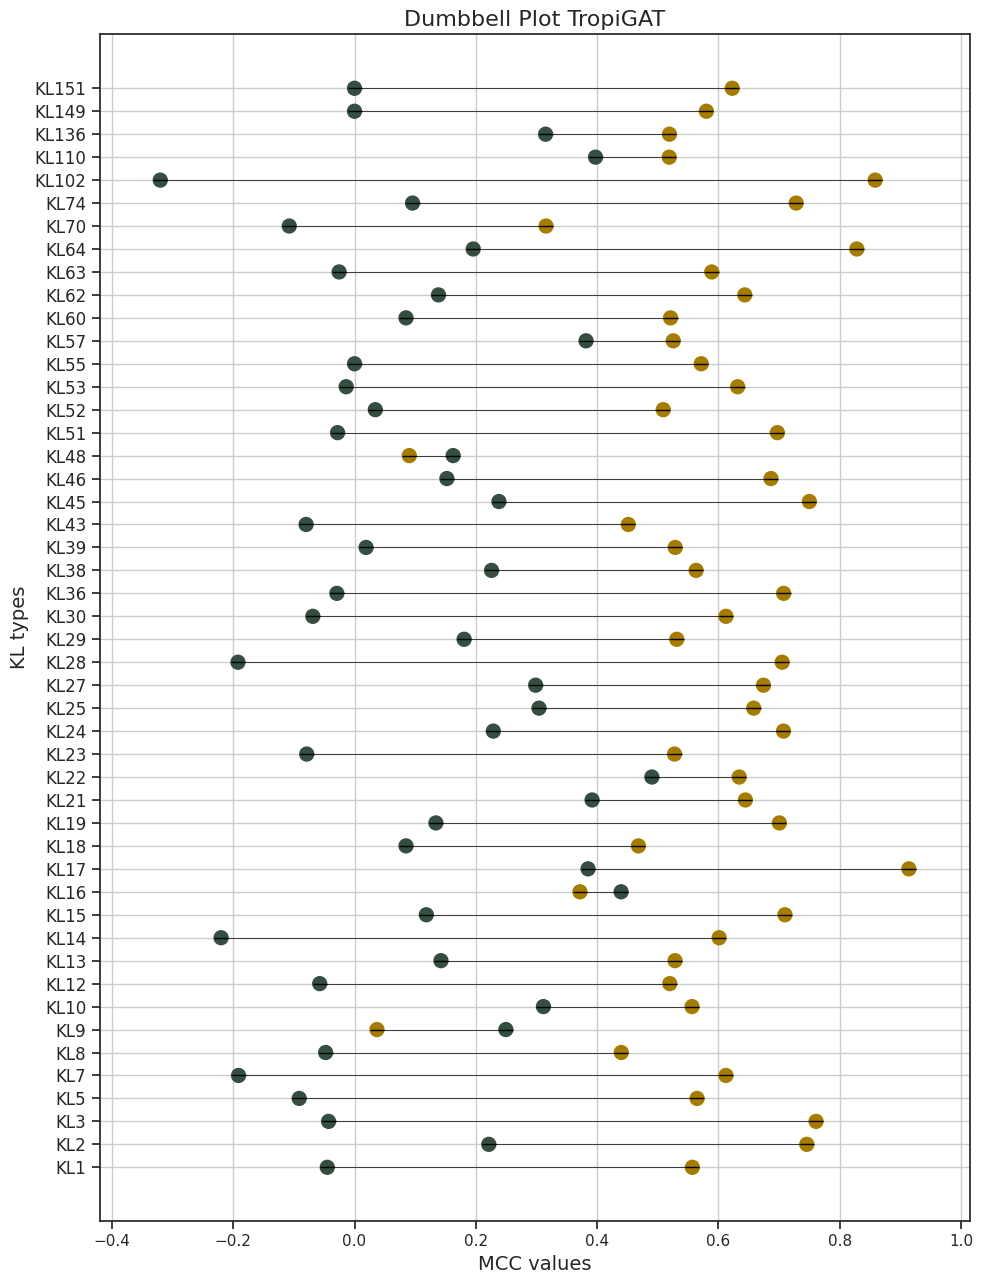

In [188]:
from scipy.stats import pearsonr
# Set seaborn style
sns.set(style="ticks")

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 13))

# Plot MCC_lytic and MCC_prophage values for each KL type
for i, row in df_tropigat.iterrows():
    ax.scatter([row["MCC_lytic"], row["MCC_prophage"]], [i, i], color=['#344e41ff', '#a67c00ff'], s=100)  
    ax.plot([row["MCC_lytic"], row["MCC_prophage"]], [i, i], marker='_', color='black', markersize=10, linewidth= 0.5) 

# Set y-ticks and labels
ax.set_yticks(range(len(df_tropigat)))
ax.set_yticklabels(df_tropigat["KL type"], fontsize=12)  

# Add labels and title
ax.set_xlabel('MCC values', fontsize=14) 
ax.set_ylabel('KL types', fontsize=14)  
ax.set_title('Dumbbell Plot TropiGAT', fontsize=16) 

# Set x-limits to shorten the line
min_mcc = min(df_tropigat["MCC_lytic"].min(), df_tropigat["MCC_prophage"].min())
max_mcc = max(df_tropigat["MCC_lytic"].max(), df_tropigat["MCC_prophage"].max())
ax.set_xlim(min_mcc - 0.1, max_mcc + 0.1)  

# Show plot
plt.grid(True)
plt.tight_layout()
#sns.despine()
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/dumbbell.TropiGAT.0203.svg', dpi = 500)
plt.show()


#correlation_coefficient, p_value = pearsonr(df_tropigat["MCC_lytic"], df_tropigat["MCC_prophage"])

#print("Pearson correlation coefficient:", correlation_coefficient)
#print("P-value:", p_value)


> Matrices TropiSeq : 

In [12]:
import pandas as pd 
import os 

path_seqbased = "/media/concha-eloko/Linux/PPT_clean/RF_2912_models_info"

header_metric = ["KL_type", "Effectifs","MCC","F1","recall","Accuracy","AUC"]
seqbased_df = pd.read_csv(f"{path_seqbased}/RF_report.0.75.0702.tsv", sep = "\t", header = 0)

seqbased_df

,KL_type,n_prophages,MCC,F1,recall,Accuracy,AUC
0,KL41,10,0.000000,0.000000,0.000000,0.833333,0.500000
1,KL30,93,0.390511,0.466667,0.411765,0.857143,0.674303
2,KL6,12,0.000000,0.000000,0.000000,0.800000,0.500000
3,KL19,73,0.747625,0.758621,0.611111,0.924731,0.805556
4,KL25,269,0.824502,0.851485,0.877551,0.953560,0.922352
...,...,...,...,...,...,...,...
84,KL20,18,-0.118345,0.000000,0.000000,0.727273,0.470588
85,KL142,14,-0.108465,0.000000,0.000000,0.777778,0.466667
86,KL58,6,0.000000,0.000000,0.000000,0.750000,0.500000
87,KL124,12,0.534522,0.500000,0.333333,0.866667,0.666667


In [18]:

sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat =  make_labels(bp_df, predictor = "tropiseq")
dico_mcc_tropiseq = get_MCC_lytic(sorted_dict_tropigat , labels_tropigat, count_kltypes_tropigat)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 128/128 [00:00<00:00, 186.91it/s]
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/concha-eloko/Linux/conda_envs/ML_work/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_divisio

In [19]:
Counter(labels_tropigat["KL102"]["y_pred"])

Counter({1: 21})

In [20]:
21/22*100

95.45454545454545

In [134]:
for kltype in dico_mcc_tropiseq : 
    try : 
        mcc_train = seqbased_df[seqbased_df["KL_type"] == kltype]["MCC"].values[0]
        count = seqbased_df[seqbased_df["KL_type"] == kltype]["n_prophages"].values[0]
        dico_mcc_tropiseq[kltype].update({"prophage" : {"MCC" : mcc_train, "Count" : count}})
    except Exception as e :
        print(e, kltype)

dico_mcc_tropiseq

index 0 is out of bounds for axis 0 with size 0 KL37
index 0 is out of bounds for axis 0 with size 0 KL66


{'KL2': {'lytic_phages': {'MCC': 0.40802826981168505,
   'Recall': 0.1875,
   'Count': 16},
  'prophage': {'MCC': 0.819829538453252, 'Count': 351}},
 'KL3': {'lytic_phages': {'MCC': 0.3429971702850177,
   'Recall': 0.25,
   'Count': 12},
  'prophage': {'MCC': 0.9772845968667996, 'Count': 145}},
 'KL8': {'lytic_phages': {'MCC': -0.015873015873015872,
   'Recall': 0.0,
   'Count': 1},
  'prophage': {'MCC': 0.0, 'Count': 20}},
 'KL14': {'lytic_phages': {'MCC': 0.19602615296545545,
   'Recall': 0.1,
   'Count': 10},
  'prophage': {'MCC': 0.8978479286969768, 'Count': 130}},
 'KL15': {'lytic_phages': {'MCC': 1.0, 'Recall': 1.0, 'Count': 1},
  'prophage': {'MCC': 0.7141922411621274, 'Count': 204}},
 'KL16': {'lytic_phages': {'MCC': 0.2984565685101429,
   'Recall': 0.2,
   'Count': 5},
  'prophage': {'MCC': 0.4759858191164942, 'Count': 27}},
 'KL17': {'lytic_phages': {'MCC': 0.7014723744122017,
   'Recall': 0.5,
   'Count': 2},
  'prophage': {'MCC': 0.968670567396128, 'Count': 481}},
 'KL18': 

In [154]:
mcc_lytic = [value["lytic_phages"]["MCC"] for key,value in dico_mcc_tropiseq.items() if key not in ["KL37", "KL66"]]
mcc_prophage = [value["prophage"]["MCC"] for key,value in dico_mcc_tropiseq.items() if key not in ["KL37", "KL66"]]
kltypes_list = [kltype for kltype in list(dico_mcc_tropiseq.keys()) if kltype not in ["KL37", "KL66"]]

df_tropiseq = pd.DataFrame([kltypes_list,mcc_lytic, mcc_prophage]).T
df_tropiseq.columns = ["KL type", "MCC_lytic", "MCC_prophage"]

df_tropiseq

,KL type,MCC_lytic,MCC_prophage
0,KL2,0.408028,0.81983
1,KL3,0.342997,0.977285
2,KL8,-0.015873,0.0
3,KL14,0.196026,0.897848
4,KL15,1.0,0.714192
5,KL16,0.298457,0.475986
6,KL17,0.701472,0.968671
7,KL18,0.568112,1.0
8,KL21,0.701472,0.925881
9,KL22,0.617273,0.864714


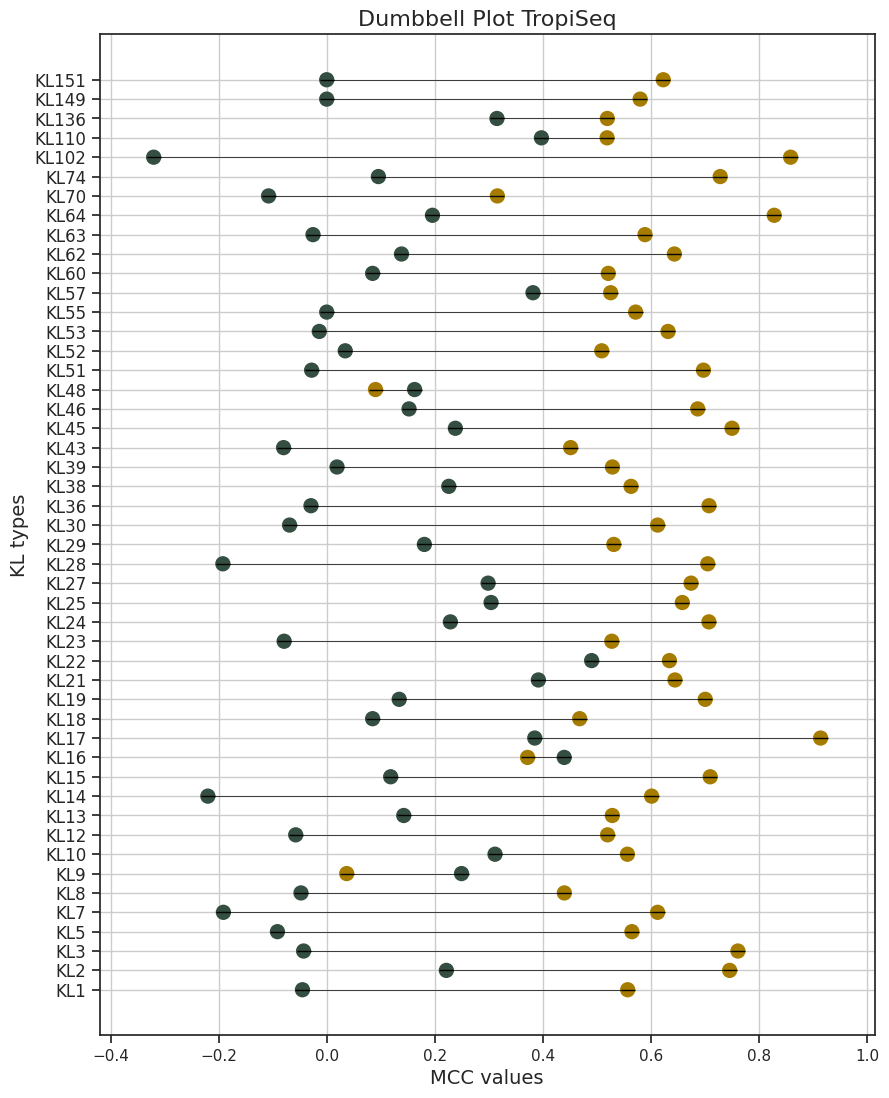

-0.057202232021862656


In [155]:
from scipy.stats import pearsonr
# Set seaborn style
sns.set(style="ticks")

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 13))

# Plot MCC_lytic and MCC_prophage values for each KL type
for i, row in df_tropigat.iterrows():
    ax.scatter([row["MCC_lytic"], row["MCC_prophage"]], [i, i], color=['#344e41ff', '#a67c00ff'], s=100)  
    ax.plot([row["MCC_lytic"], row["MCC_prophage"]], [i, i], marker='_', color='black', markersize=10, linewidth= 0.5) 

# Set y-ticks and labels
ax.set_yticks(range(len(df_tropigat)))
ax.set_yticklabels(df_tropigat["KL type"], fontsize=12)  

# Add labels and title
ax.set_xlabel('MCC values', fontsize=14) 
ax.set_ylabel('KL types', fontsize=14)  
ax.set_title('Dumbbell Plot TropiSeq', fontsize=16) 

# Set x-limits to shorten the line
min_mcc = min(df_tropigat["MCC_lytic"].min(), df_tropigat["MCC_prophage"].min())
max_mcc = max(df_tropigat["MCC_lytic"].max(), df_tropigat["MCC_prophage"].max())
ax.set_xlim(min_mcc - 0.1, max_mcc + 0.1)  

# Show plot
plt.grid(True)
#plt.tight_layout()
#sns.despine()
plt.savefig('/media/concha-eloko/Linux/papers/PPT/figures_draft/dumbbell.TropiSeq.0203.svg', dpi = 500)
plt.show()


correlation_coefficient, p_value = pearsonr(df_tropigat["MCC_lytic"], df_tropigat["MCC_prophage"])
print(correlation_coefficient)

***